# Let's Train GPT-2 with RoPE + GLU



### Configure the machine and install packages


In [1]:
import os
#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow

Running on darwin


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [3]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.6.2
Flax version 0.10.4
Available devices: 1


/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_76662/2488604009.py:22: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


237 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the GPT-2 model and perform a sanity check

In [4]:
from functools import partial

from jax.sharding import Mesh, PartitionSpec, NamedSharding
from flax import nnx

from jaxpt.infer import generate_completions
from jaxpt.models import GLU_RoPE_GPT, GLU_RoPE_GPTConfig
from jaxpt.utils import count_params, create_sharded_model

"""
+--------------+---------+--------+------+
| Model        | Layers  | Heads  | Embd |
+--------------+---------+--------+------+
| gpt2-medium  | 24      | 16     | 1024 |
| gpt2-large   | 36      | 20     | 1280 |
| gpt2-xl      | 48      | 25     | 1600 |
+--------------+---------+--------+------+
"""

mesh = Mesh(devices, ("devices",))
spec = PartitionSpec("devices",)
sharding = NamedSharding(mesh, spec)


key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = GLU_RoPE_GPTConfig(dtype=jnp.bfloat16, \
                   n_layer=30, \
                   vocab_size=50304, \
                   block_size=2048,
                   n_head=9,
                   n_embed=576,
                   n_mlp_hidden=1536,
                   sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
with mesh:
    m = create_sharded_model(GLU_RoPE_GPT, config, rngs)
    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)

    total_params = count_params(m)
    print(f"Parameter Count: {total_params:,}")
    nnx.display(state)

    completions = generate_completions(m, num_completions=5, max_length=21, prefix="Ducks quack, donkeys bray, cats mew, horses")
    for completion in completions:
        print(completion)


Parameter Count: 148,553,856


Ducks quack, donkeys bray, cats mew, horsesById Newcastle Newcastle Newcastle Newcastle Newcastle
Ducks quack, donkeys bray, cats mew, horses������
Ducks quack, donkeys bray, cats mew, horses eleven eleven eleven eleven eleven eleven
Ducks quack, donkeys bray, cats mew, horses Ling Ling Ling Ling Ling Ling
Ducks quack, donkeys bray, cats mew, horses Newcastle Newcastle Newcastle Newcastle Newcastle Newcastle


In [5]:
jax.debug.visualize_array_sharding(m.wte.embedding.value)

         
         
         
         
         
  CPU 0  
         
         
         
         
         

### Configure Training Run

In [6]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/workspace/runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250721_uzmhiq
Checkpoint directory: /Users/vikram/dev/jaxpt/checkpoints
Log directory: /Users/vikram/dev/jaxpt/logs


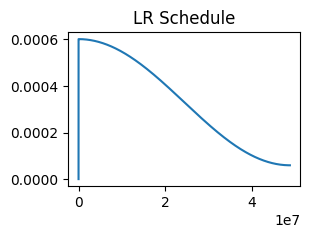

weight decay param count: 148,414,464
tokens/batch: 2,048
block size: 128
sub-batch size: 16
no. gradient accumulation steps: 1
effective batch size per device:  16
effective batch size: 16
max steps: 48828125


In [7]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens: int = int(100e9)
  num_tokens_per_batch: int = 2**11 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 16 * num_devices
  T: int = 128
  max_steps: int = num_tokens // num_tokens_per_batch # 1 epoch (99 shards of the dataset should be around 18883, but Karpathy used 19073 for some reason)
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 1
  eval_interval: int = 2000
  checkpoint_interval: int = 2000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**14,
  mB=16,
  T=1024,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ warmup_with_cosine_decay_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)


tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95) #, weight_decay=0.1, mask=weight_decay_mask)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


### DataLoader and Validation Setup



In [8]:
from jaxpt.dataloaders import DataLoader, HuggingfaceDataLoader, CloudDataLoader, BlendedCloudDataLoader

batch_size = trconf.T * trconf.mB * trconf.grad_accumulation_steps
batch_memory = batch_size*2
print(f"Batch Size (Tokens): {batch_size:,} | Batch Memory: {batch_memory/1024} MB")

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB * DATA_DIMS,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
'''
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

'''
train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")
'''
'''
train_dl = BlendedCloudDataLoader(
    device_rank=1,
    block_size=trconf.T,
    batch_size=trconf.mB,
    bucket_names=["jaxpt_datasets", "jaxpt_datasets", "jaxpt_datasets"],
    bucket_prefixes=["smollm-corpus/processed/fineweb-edu-dedup",
                     "smollm-corpus/processed/python-edu",
                     "smollm-corpus/processed/cosmopedia-v2"],
    proportions=[87, 2, 11],
    label="train"
)
'''
train_dl = DataLoader(dirpath="/content/jaxpt/datasets/panchatantra-ryder/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")



Batch Size (Tokens): 2,048 | Batch Memory: 4.0 MB


FileNotFoundError: [Errno 2] No such file or directory: '/content/jaxpt/datasets/panchatantra-ryder/processed'

In [9]:
from jaxpt.utils import append_to_csv

train_losses = []
val_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{run_dirname}_valid.csv", ["step", "loss"])
step = 0
start = None

### Let's train the model

0 | lr: 8.39e-07 | loss: 10.9375 | time: 66688.24ms | tokens processed: 2,048 | tok/sec: 30.71
1 | lr: 1.68e-06 | loss: 10.8125 | time: 47497.09ms | tokens processed: 4,096 | tok/sec: 43.12
2 | lr: 2.52e-06 | loss: 10.4375 | time: 46.86ms | tokens processed: 6,144 | tok/sec: 43,704.23
3 | lr: 3.36e-06 | loss: 10.2500 | time: 42.69ms | tokens processed: 8,192 | tok/sec: 47,969.43
4 | lr: 4.20e-06 | loss: 10.0625 | time: 40.50ms | tokens processed: 10,240 | tok/sec: 50,569.18
5 | lr: 5.03e-06 | loss: 9.8125 | time: 40.45ms | tokens processed: 12,288 | tok/sec: 50,634.47
6 | lr: 5.87e-06 | loss: 9.6250 | time: 38.77ms | tokens processed: 14,336 | tok/sec: 52,825.38
7 | lr: 6.71e-06 | loss: 9.5000 | time: 45.82ms | tokens processed: 16,384 | tok/sec: 44,692.22
8 | lr: 7.55e-06 | loss: 9.5000 | time: 47.36ms | tokens processed: 18,432 | tok/sec: 43,243.95
9 | lr: 8.39e-06 | loss: 9.3125 | time: 47.74ms | tokens processed: 20,480 | tok/sec: 42,895.84
10 | lr: 9.23e-06 | loss: 9.3750 | time: 

Exception ignored in: <function _xla_gc_callback at 0x7ee75657b740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


2730 | lr: 6.00e-04 | loss: 0.2461 | time: 475.44ms | tokens processed: 5,593,088 | tok/sec: 4,307.57
2731 | lr: 6.00e-04 | loss: 0.2617 | time: 43.25ms | tokens processed: 5,595,136 | tok/sec: 47,352.51
2732 | lr: 6.00e-04 | loss: 0.2793 | time: 43.97ms | tokens processed: 5,597,184 | tok/sec: 46,577.35
2733 | lr: 6.00e-04 | loss: 0.2695 | time: 50.63ms | tokens processed: 5,599,232 | tok/sec: 40,447.39
2734 | lr: 6.00e-04 | loss: 0.2559 | time: 50.75ms | tokens processed: 5,601,280 | tok/sec: 40,357.89
2735 | lr: 6.00e-04 | loss: 0.3086 | time: 47.75ms | tokens processed: 5,603,328 | tok/sec: 42,890.70
2736 | lr: 6.00e-04 | loss: 0.2812 | time: 44.76ms | tokens processed: 5,605,376 | tok/sec: 45,755.15
2737 | lr: 6.00e-04 | loss: 0.2539 | time: 43.07ms | tokens processed: 5,607,424 | tok/sec: 47,555.94
2738 | lr: 6.00e-04 | loss: 0.2344 | time: 41.97ms | tokens processed: 5,609,472 | tok/sec: 48,795.63
2739 | lr: 6.00e-04 | loss: 0.2656 | time: 40.88ms | tokens processed: 5,611,520 |

Exception ignored in: <function _xla_gc_callback at 0x7ee75657b740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


2875 | lr: 6.00e-04 | loss: 0.2676 | time: 42.10ms | tokens processed: 5,890,048 | tok/sec: 48,644.76
2876 | lr: 6.00e-04 | loss: 0.2520 | time: 41.86ms | tokens processed: 5,892,096 | tok/sec: 48,920.13
2877 | lr: 6.00e-04 | loss: 0.2871 | time: 40.94ms | tokens processed: 5,894,144 | tok/sec: 50,023.20
2878 | lr: 6.00e-04 | loss: 0.2734 | time: 49.07ms | tokens processed: 5,896,192 | tok/sec: 41,732.95
2879 | lr: 6.00e-04 | loss: 0.2773 | time: 46.89ms | tokens processed: 5,898,240 | tok/sec: 43,679.11
2880 | lr: 6.00e-04 | loss: 0.2910 | time: 43.41ms | tokens processed: 5,900,288 | tok/sec: 47,181.89
2881 | lr: 6.00e-04 | loss: 0.2656 | time: 42.68ms | tokens processed: 5,902,336 | tok/sec: 47,990.61
2882 | lr: 6.00e-04 | loss: 0.2617 | time: 44.49ms | tokens processed: 5,904,384 | tok/sec: 46,033.45
2883 | lr: 6.00e-04 | loss: 0.2295 | time: 43.33ms | tokens processed: 5,906,432 | tok/sec: 47,263.14
2884 | lr: 6.00e-04 | loss: 0.2617 | time: 43.91ms | tokens processed: 5,908,480 |

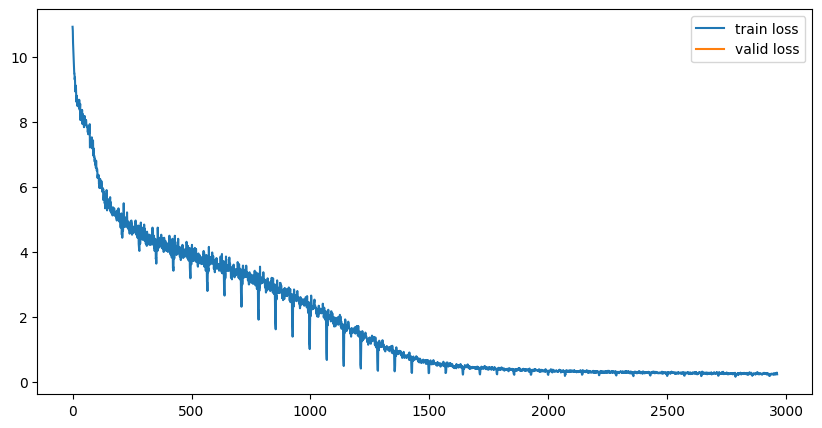

In [10]:
%matplotlib inline

import time
import logging
import warnings

import matplotlib.pyplot as plt


def loss_fn(model, batch, targets):
    logits = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
    return loss.mean()


@nnx.jit
def train_step(model, optimizer, batch, targets):
    loss, grads = nnx.value_and_grad(loss_fn, has_aux=False)(model, batch, targets)
    optimizer.update(grads)
    return loss


with mesh:
  m.train()
  try:
    while step < trconf.max_steps:
      start = time.time()
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), sharding)
      target = jax.device_put(target.squeeze(), sharding)
      loss = train_step(m, optimizer, batch, target)
      if step % trconf.print_interval == 0:
        if start is None:
          start = time.time()
          iter_time = 0
          sub_step_time = 0
          tokes_per_sec = 0
          tokens_processed = 0
        else:
          iter_time = time.time() - start
          sub_step_time = iter_time / trconf.grad_accumulation_steps
          tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
          tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T

        loss = loss.item()
        lr = warmup_with_cosine_decay_schedule(step)
        train_losses.append((step, loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr:0.2e} | loss: {loss:0.4f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}")#, end="\r")
      if step % trconf.eval_interval == 0:
        pass
        #valid_loss, completions = evaluate(m)
        #valid_loss = jnp.float32(valid_loss)
        #val_losses.append((step, valid_loss))
        #append_to_csv(log_dir / f"{run_dirname}_valid.csv", [step, valid_loss])
        #print(f"valid loss: {valid_loss:0.4f}"  )
        #for completion in completions:
        #  print(completion)
      #if step > 0 and trconf.checkpoint_interval > 0 and step % trconf.checkpoint_interval == 0:
        #save_checkpoint(m, run_dirname, step)
      step += 1

  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  #valid_loss, completions = evaluate(m)
  #valid_loss = jnp.float32(valid_loss)
  #print(f"valid loss: {valid_loss:0.4f}")
  #print(f"completions: {completions}")
  #for completion in completions:
  #  print(completion)
  plt.figure(figsize=(10, 5))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label="valid loss")
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()
